## Interesting Visulizations
### Return the top-k interesting visulaizations from any database!
#### Submmitters: Ido Tausi, Afek Nahum

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency, spearmanr
from sklearn.preprocessing import LabelEncoder


In [201]:

# Importing the dataset
dataset = pd.read_csv('StudentsDepression.csv')
target_column = 'Depression'

# dataset = pd.read_csv('BillionairesStatistics.csv')

dataset.head()
dataset[target_column].value_counts()

dataset = dataset.drop(columns=['Profession', 'Work Pressure', 'Job Satisfaction'])


In [202]:
def fill_missing_values(dataset):
    for column in dataset.columns:
        # print(f'{column} data type: {dataset[column].dtype}, is_numeric: {pd.api.types.is_numeric_dtype(dataset[column])}')
        if pd.api.types.is_numeric_dtype(dataset[column]):
            dataset.fillna(dataset[column].mean(), inplace=True)

    return dataset

fill_missing_values(dataset)



,Gender,Age,City,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,33,Visakhapatnam,5,8.97,2,5-6 hours,Healthy,B.Pharm,Yes,3,1.0,No,1
1,Female,24,Bangalore,2,5.90,5,5-6 hours,Moderate,BSc,No,3,2.0,Yes,0
2,Male,31,Srinagar,3,7.03,5,Less than 5 hours,Healthy,BA,No,9,1.0,Yes,0
3,Female,28,Varanasi,3,5.59,2,7-8 hours,Moderate,BCA,Yes,4,5.0,Yes,1
4,Female,25,Jaipur,4,8.13,3,5-6 hours,Moderate,M.Tech,Yes,1,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,Female,27,Surat,5,5.75,5,5-6 hours,Unhealthy,Class 12,Yes,7,1.0,Yes,0
27897,Male,27,Ludhiana,2,9.40,3,Less than 5 hours,Healthy,MSc,No,0,3.0,Yes,0
27898,Male,31,Faridabad,3,6.61,4,5-6 hours,Unhealthy,MD,No,12,2.0,No,0
27899,Female,18,Ludhiana,5,6.88,2,Less than 5 hours,Healthy,Class 12,Yes,10,5.0,No,1


In [203]:
def bin_numerical_columns(dataframe):
    binned_cloumns = []
    dataframe = dataframe.copy()
    for column in dataframe.columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            if dataframe[column].nunique() < 10:
                continue
            # remove outliers
            q1 = dataframe[column].quantile(0.25)
            q3 = dataframe[column].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            dataframe = dataframe[(dataframe[column] > lower_bound) & (dataframe[column] < upper_bound)]
            # TODO: decide on bins sizes
            bins_number = 10
            dataframe[column] = pd.cut(dataframe[column], bins=bins_number, right=True)
            binned_cloumns.append(column)
    return dataframe, binned_cloumns


In [204]:
def subset_data(dataframe, column, value):
    return dataframe[dataframe[column] == value]

def create_subsets_for_column(dataframe, column, subset_threshold=10):
    subsets = {}
    for value, count in dataframe[column].value_counts().items():
        # print(f'{value}: {count}')
        if count < subset_threshold:
            continue
        subsets[value] = subset_data(dataframe, column, value)
    return subsets

def create_subsets(dataframe):
    subsets = {}
    for column in dataframe.columns:
        # TODO: calculate subset threshold
        subsets[column] = create_subsets_for_column(dataframe, column)
    return subsets

binned_dataset, binned_columns = bin_numerical_columns(dataset)
subsets_age = create_subsets_for_column(binned_dataset, 'Age')
for key, value in subsets_age.items():
    print(f'{key}: {len(value)}')
    # print(type(value))



# 
# subsets = {
#     "Age": {
#         (18, 20]: dataframe,
#         (20, 22]: dataframe,
#         ...
#     },
#     "CGPA": {
#         (6.5, 7.0]: dataframe,
#         (7.0, 7.5]: dataframe,
#         ...
#     },
#     ...
# }

(17.975, 20.5]: 5381
(25.5, 28.0]: 4749
(30.5, 33.0]: 4581
(20.5, 23.0]: 4530
(23.0, 25.5]: 4041
(28.0, 30.5]: 3095
(33.0, 35.5]: 1477
(35.5, 38.0]: 16


In [205]:
def map_column_values(dataframe, column_names, mappings):
    dataframe = dataframe.copy()
    for column_name, mapping in zip(column_names, mappings):
        dataframe[column_name] = dataframe[column_name].map(mapping)
    return dataframe

sleep_duration_map = {
    'Less than 5 hours': 1,
    '5-6 hours': 2,
    '7-8 hours': 3,
    'More than 8 hours': 4,
    'Others': 5 
}

dietary_habits_map = {
    'Healthy': 1,
    'Moderate': 2,
    'Unhealthy': 3,
    'Others': 4
}

gender_map = {
    'Male': 1,
    'Female': 0
}

suicidal_thoughts_map = {
    'Yes': 1,
    'No': 0
}

history_of_mental_health_map = {
    'Yes': 1,
    'No': 0
}


map_of_binned_columns = {}
for bin_column in binned_columns:
    map_of_binned_columns[bin_column] = {}
    for interval_key in binned_dataset[bin_column].value_counts().keys():
        map_of_binned_columns[bin_column][interval_key] = interval_key.mid

binned_dataset = map_column_values(binned_dataset, column_names=['Sleep Duration', 'Dietary Habits', 'Gender', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'], 
                                   mappings=[sleep_duration_map, dietary_habits_map, gender_map, suicidal_thoughts_map, history_of_mental_health_map])

binned_dataset = map_column_values(binned_dataset, column_names=binned_columns, mappings=[map_of_binned_columns[column] for column in binned_columns])
binned_dataset.head()


,Gender,Age,City,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,1,31.75,Visakhapatnam,5,8.7575,2,2,1,B.Pharm,1,3.000,1.0,0,1
1,0,24.25,Bangalore,2,5.7755,5,2,2,BSc,0,3.000,2.0,1,0
2,1,31.75,Srinagar,3,7.2665,5,1,1,BA,0,9.000,1.0,1,0
3,0,26.75,Varanasi,3,5.7755,2,3,2,BCA,1,4.200,5.0,1,1
4,0,24.25,Jaipur,4,8.2605,3,2,2,M.Tech,1,0.594,1.0,0,0


In [206]:
subset_age_18_20 = subsets_age[list(subsets_age.keys())[2]]

subsets_age.keys()

dict_keys([Interval(17.975, 20.5, closed='right'), Interval(25.5, 28.0, closed='right'), Interval(30.5, 33.0, closed='right'), Interval(20.5, 23.0, closed='right'), Interval(23.0, 25.5, closed='right'), Interval(28.0, 30.5, closed='right'), Interval(33.0, 35.5, closed='right'), Interval(35.5, 38.0, closed='right')])

In [214]:
def get_subsets_correlations(dataframe, target_column):
    correlations = {}
    subsets = create_subsets(dataframe)
    for filter_column, filtered_subsets in subsets.items():
        if filter_column == target_column:
            continue
        for subset_key, subset in filtered_subsets.items():
            if subset.shape[0] < 50:
                continue
            for column in subset.columns:
                if column == target_column or column == filter_column:
                    continue
                if pd.api.types.is_numeric_dtype(subset[column]):
                    correlation, p_value = spearmanr(subset[column], subset[target_column])
                    if p_value < 0.05:
                        # TODO: note the correlation is positive or negative
                        correlations[(filter_column, subset_key, column)] = correlation
    
    top_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
    return top_correlations


def get_column_correlations(dataframe, target_column, mappings={}):
    correlations = {}
    for column in dataframe.columns:
        if column == target_column:
            continue
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            correlation, _ = spearmanr(dataframe[column], dataframe[target_column])
            correlations[column] = correlation
    return correlations

def get_k_top_correlations(dataframe, target_column, k=10):
    results = {}
    correlations = get_column_correlations(dataframe, target_column)
    print(correlations)
    subsets_correlations = get_subsets_correlations(dataframe, target_column)
    for (filter_column, subset_key, column), correlation in subsets_correlations:
        results[(filter_column, subset_key, column)] = abs(correlation - correlations[column])
    top_correlations = sorted(results.items(), key=lambda x: x[1], reverse=True)
    return top_correlations[:k]

get_k_top_correlations(binned_dataset, target_column, k=10)


{'Gender': 0.0018467732353774407, 'Academic Pressure': 0.47248047760341944, 'Study Satisfaction': -0.16823010856067103, 'Sleep Duration': -0.08730501747269921, 'Dietary Habits': 0.20752016720151734, 'Have you ever had suicidal thoughts ?': 0.5465241540258814, 'Financial Stress': 0.36285568454795586, 'Family History of Mental Illness': 0.05359241215344828}


[(('Degree', 'MHM', 'Financial Stress'), 0.19903481715707289),
 (('Degree', 'ME', 'Academic Pressure'), 0.1759736659497712),
 (('Degree', 'BE', 'Have you ever had suicidal thoughts ?'),
  0.17528014000558234),
 (('City', 'Ahmedabad', 'Academic Pressure'), 0.13102667473599394),
 (('Academic Pressure', 1, 'Have you ever had suicidal thoughts ?'),
  0.12635476423652758),
 (('City', 'Vadodara', 'Financial Stress'), 0.12060577104273953),
 (('Degree', 'MHM', 'Have you ever had suicidal thoughts ?'),
  0.11540136088392877),
 (('Degree', 'MA', 'Dietary Habits'), 0.1145166689989714),
 (('Academic Pressure', 1, 'Study Satisfaction'), 0.10663564329060411),
 (('Academic Pressure', 5, 'Financial Stress'), 0.10653991164769588)]

In [208]:

def is_correlated(dataset, column1, column2):
    """
    :param column1: dataframe column of the first feature
    :param column2: dataframe column of the second feature
    :return: chi-square correlation between the two features
    """

    # create a contingency table
    contingency_table = pd.crosstab(dataset[column1], dataset[column2])

    # calculate the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    return chi2, p, dof, expected


def cramers_v(x, y):
    # Ensure inputs are processed properly
    if isinstance(x, pd.Categorical):
        print("hi")
        x = x.codes
    if isinstance(y, pd.Categorical):
        y = y.codes
        print("hi")

    # Create a confusion matrix
    confusion_matrix = pd.crosstab(x, y)

    # Perform chi-square test
    chi2, _, _, _ = chi2_contingency(confusion_matrix)

    # Calculate Cramér's V
    n = confusion_matrix.sum().sum()  # Total number of observations
    r, k = confusion_matrix.shape  # Rows and columns of the matrix
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

def theils_u(x, y):
    # Convert categorical data to numeric codes
    if isinstance(x, pd.Categorical):
        x = x.codes
    if isinstance(y, pd.Categorical):
        y = y.codes

    # Encode the variables
    le = LabelEncoder()
    x_encoded = le.fit_transform(pd.Series(x).dropna())
    y_encoded = le.fit_transform(pd.Series(y).dropna())
    
    # Joint and marginal probabilities
    joint_prob = pd.crosstab(x_encoded, y_encoded, normalize=True)
    x_prob = joint_prob.sum(axis=1)
    y_prob = joint_prob.sum(axis=0)
    
    # Entropy calculations
    h_x = -np.sum(x_prob * np.log2(x_prob + 1e-9))
    h_xy = -np.sum(joint_prob.values.flatten() * np.log2(joint_prob.values.flatten() + 1e-9))
    
    # Prevent division by zero and ensure positivity
    if h_x <= 0:
        return 0
    return max(0, (h_x - h_xy) / (h_x + 1e-9))

# is_correlated(binned_dataset, 'Age', 'Depression') 
# Calculate Cramér's V
# cramers_v_result = cramers_v(binned_dataset['Age'], binned_dataset['Depression'])
# print(f"Cramér's V Age & Depression: {cramers_v_result}")


# cramers_v_result = cramers_v(binned_dataset['Sleep Duration'], binned_dataset['Depression'])
# print(f"Cramér's V Sleep Duration & Depression: {cramers_v_result}")


# cramers_v_result = cramers_v(subset_age_18_20['Depression'], subset_age_18_20['Depression'])
# print(f"Cramér's V Sleep Duration & 17-18 VS. Depression: {cramers_v_result}")

# sleep_duration_map = {
#     'Less than 5 hours': 1,
#     '5-6 hours': 2,
#     '7-8 hours': 3,
#     'More than 8 hours': 4,
#     'Others': 5  # Or you can drop 'Others' if it doesn't make sense to assign a value
# }

# binned_dataset['Sleep_Duration_numeric'] = binned_dataset['Sleep Duration'].map(sleep_duration_map)

# correlation, p_value = spearmanr(binned_dataset['Sleep Duration'], binned_dataset['Depression'])
# print(f"Spearman's Rank Correlation between Sleep Duration and Depression: {correlation}")
# print(f"P-value: {p_value}")

# correlation = binned_dataset['Sleep_Duration_numeric'].corr(binned_dataset['Depression'])
# print(f"Pearson's Correlation between Age and Depression: {correlation}")

# theils_u_result = theils_u(binned_dataset['Age'], binned_dataset['Depression'])
# print(f"Theil's U (Age -> Depression): {theils_u_result}")


In [209]:
print(binned_dataset['Age'].head())
print(binned_dataset['Depression'].head())
print(binned_dataset['Depression'].value_counts())


0    31.75
1    24.25
2    31.75
3    26.75
4    24.25
Name: Age, dtype: category
Categories (10, float64): [19.2375 < 21.7500 < 24.2500 < 26.7500 ... 34.25 < 36.75 < 39.25 < 41.75]
0    1
1    0
2    0
3    1
4    0
Name: Depression, dtype: int64
Depression
1    16330
0    11550
Name: count, dtype: int64


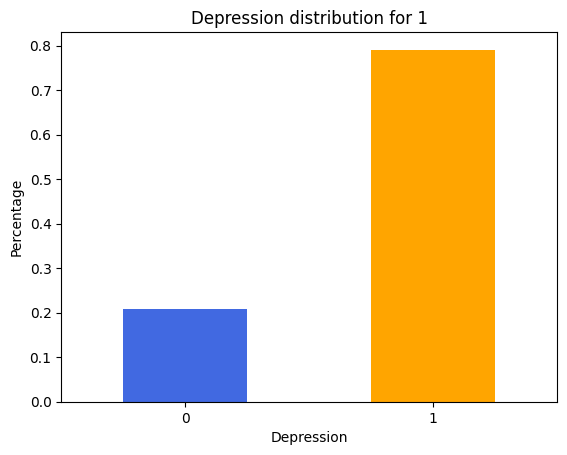

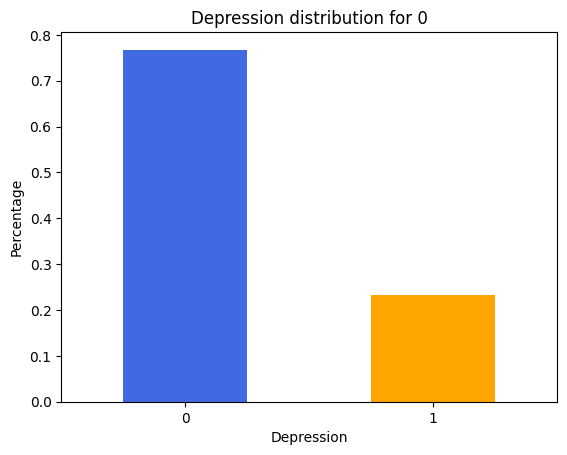

In [210]:
import matplotlib.pyplot as plt

def show_bar_chart_subsets(dataframe, column_subsets, target_column):
    for subset_value, subset_data in column_subsets.items():
        column_to_show = subset_data[target_column]
        
        # Bar chart configuration
        plt.title(f'{target_column} distribution for {subset_value}')
        plt.xlabel(target_column)
        plt.ylabel('Percentage')
        
        # Plot the bar chart
        value_counts = column_to_show.value_counts(normalize=True).sort_index()
        value_counts.plot(kind='bar', color=['royalblue', 'orange'])

        # Set x-ticks to 0 and 1
        rotation = 45
        if pd.api.types.is_numeric_dtype(column_to_show):
            rotation = 0
        plt.xticks(rotation=rotation)

        # Show the plot
        plt.show()

# Example usage
subset_sleep_duration = create_subsets_for_column(binned_dataset, 'Have you ever had suicidal thoughts ?')

show_bar_chart_subsets(binned_dataset, subset_sleep_duration, 'Depression')

# subset_age = create_subsets_for_column(binned_dataset, 'Age')

# show_bar_chart_subsets(binned_dataset, subset_age, 'Depression')
